# Summary

SMS dataset from here:
https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
It looks ver messy.

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
from transformers import pipeline

from jabberwocky.config import C
from jabberwocky.openai_utils import load_prompt, load_openai_api_key
from htools import *

In [5]:
cd_root()

Current directory: /Users/hmamin/jabberwocky


In [6]:
pipe = pipeline("text-classification",
                model="j-hartmann/emotion-english-distilroberta-base",
                return_all_scores=False)

In [7]:
df = pd.read_csv('data/tmp/sms.csv', encoding='latin1')
sms = df[df.v1 == 'ham'].reset_index(drop=True).v2

In [11]:
labels = pipe(sms.tolist())

In [13]:
res = pd.DataFrame(labels).assign(text=sms)
res.ends()

,label,score,text
0,surprise,0.582727,"Go until jurong point, crazy.. Available only ..."
1,joy,0.541641,Ok lar... Joking wif u oni...
4823,anger,0.492744,The guy did some bitching but I acted like i'd...
4824,neutral,0.951871,Rofl. Its true to its name


In [14]:
res.label.vcounts()

,label,label_raw_count,label_normed_count
0,neutral,2254,0.467150
1,sadness,815,0.168912
2,joy,680,0.140933
3,surprise,567,0.117513
4,anger,221,0.045803
5,fear,168,0.034819
6,disgust,120,0.024870


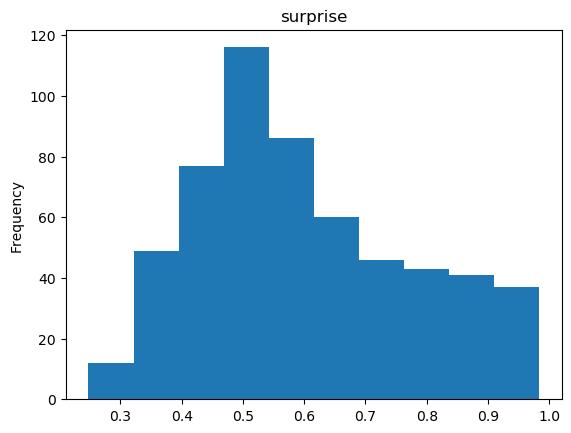

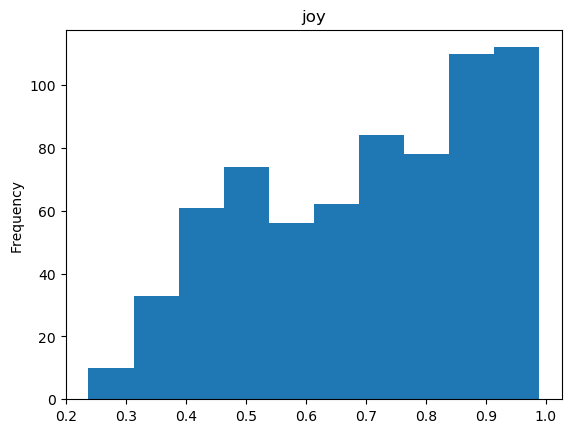

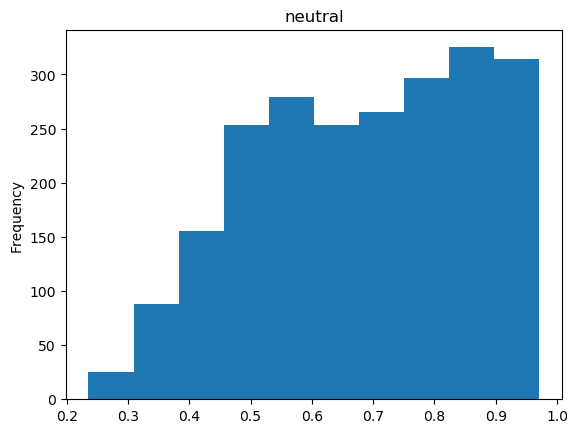

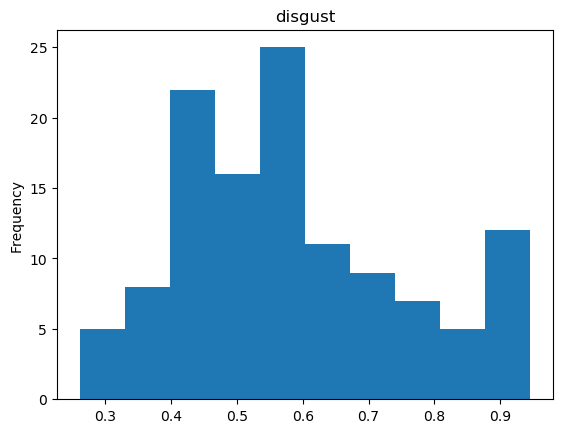

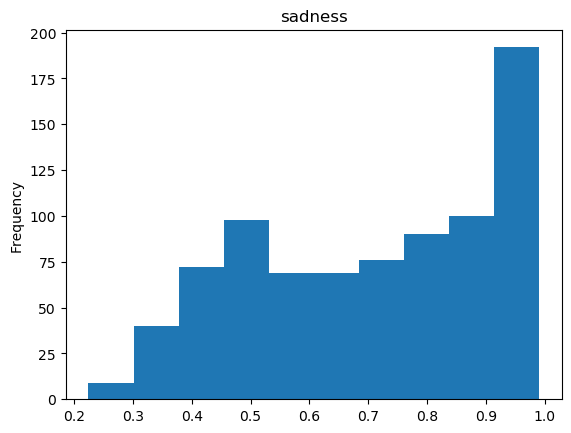

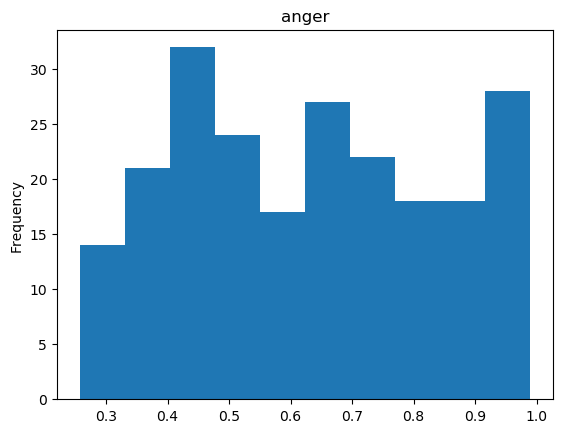

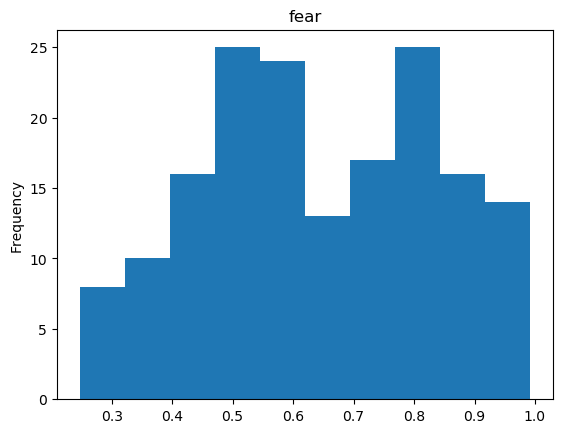

In [15]:
for label in res.label.unique():
    res[res.label == label].score.plot.hist()
    plt.title(label)
    plt.show()

In [32]:
sad = res[(res.label == 'sadness') & (res.score >= .9)]
print(f'Sad candidates: {(sad.shape[0] / sms.shape[0]):.3%} of ham texts')
sad.sort_values('score', ascending=False).ends(10).pprint(False)

Sad candidates: 4.560% of ham texts


,label,score,text
1230,sadness,0.991044,"I jus hope its true that missin me cos i'm really missin him! You haven't done anything to feel guilty about, yet."
1826,sadness,0.988056,"Sorry im getting up now, feel really bad- totally rejected that kinda me thing."
4454,sadness,0.987495,Idk. I'm sitting here in a stop and shop parking lot right now bawling my eyes out because i feel like i'm a failure in everything. Nobody wants me and now i feel like i'm failing you.
4761,sadness,0.987064,Love has one law; Make happy the person you love. In the same way friendship has one law; Never make ur friend feel alone until you are alive.... Gud night
3534,sadness,0.986705,Quite ok but a bit ex... U better go eat smth now else i'll feel guilty...
1565,sadness,0.986074,I couldn't say no as he is a dying man and I feel sad for him so I will go and I just wanted you to know I would probably be gone late into your night
3004,sadness,0.986064,Heart is empty without love.. Mind is empty without wisdom.. Eyes r empty without dreams &amp; Life is empty without frnds.. So Alwys Be In Touch. Good night &amp; sweet dreams
3103,sadness,0.986064,Heart is empty without love.. Mind is empty without wisdom.. Eyes r empty without dreams &amp; Life is empty without frnds.. So Alwys Be In Touch. Good night &amp; sweet dreams
3447,sadness,0.984922,I wish u were here. I feel so alone
238,sadness,0.984007,\Wen u miss someone


In [31]:
joy = res[(res.label == 'joy') & (res.score >= .9)]
print(f'joy candidates: {(joy.shape[0] / sms.shape[0]):.3%} of ham texts')
joy.sort_values('score', ascending=False).ends(10).pprint(False)

joy candidates: 2.694% of ham texts


,label,score,text
4217,joy,0.988959,Hi dis is yijue i would be happy to work wif Ì_ all for gek1510...
4330,joy,0.987592,Guess which pub im in? Im as happy as a pig in clover or whatever the saying is!
3130,joy,0.987586,I enjoy watching and playing football and basketball. Anything outdoors. And you?
4494,joy,0.986678,I like cheap! But iÛ÷m happy to splash out on the wine if it makes you feel better..
1496,joy,0.986389,I love to wine and dine my lady!
2976,joy,0.985359,Its good to hear from you
3295,joy,0.985256,No da. I am happy that we sit together na
1631,joy,0.985004,I love working from home :)
398,joy,0.984806,great princess! I love giving and receiving oral. Doggy style is my fave position. How about you? I enjoy making love &lt;#&gt; times per night :)
3696,joy,0.984405,I'm glad. You are following your dreams.


In [30]:
pipe('I\'m really looking forward to it.')

[{'label': 'joy', 'score': 0.9242186546325684}]

In [34]:
pipe('I\'m dreading it.')

[{'label': 'fear', 'score': 0.985512912273407}]

In [35]:
pipe('I like math.')

[{'label': 'joy', 'score': 0.9742332100868225}]

In [36]:
pipe('I sort of like math.')

[{'label': 'neutral', 'score': 0.6232054233551025}]

In [37]:
pipe('I really like math.')

[{'label': 'joy', 'score': 0.9775391817092896}]

In [38]:
pipe('I adore math.')

[{'label': 'joy', 'score': 0.963892936706543}]

## Wikipedia nationality extraction

In [347]:
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz, process
from glob import glob
import spacy
import wikipedia as wiki

from jabberwocky.external_data import wiki_page
from jabberwocky.openai_utils import ConversationManager

In [349]:
nlp = spacy.load('en_core_web_sm')

In [104]:
conv = ConversationManager(verbose=False)

In [140]:
name2page = dict.fromkeys(conv.name2gender)
failed = []
for name in tqdm(conv.name2gender):
    pretty_name = conv.process_name(name, True)
    try:
        name2page[name] = wiki_page(pretty_name)
    except Exception as e:
        print(e)
        failed.append(name)

name2page['yann_lecun'] = wiki_page('Yann Lecun', 'computer science')

  0%|          | 0/27 [00:00<?, ?it/s]

Couldn't find wikipedia page for Yann Lecun.


In [71]:
hdir(page)

{'categories': 'attribute',
 'content': 'attribute',
 'html': 'method',
 'images': 'attribute',
 'links': 'attribute',
 'original_title': 'attribute',
 'pageid': 'attribute',
 'parent_id': 'attribute',
 'references': 'attribute',
 'revision_id': 'attribute',
 'section': 'method',
 'sections': 'attribute',
 'summary': 'attribute',
 'title': 'attribute',
 'url': 'attribute'}

In [142]:
def extract_birthplace(page):
    soup = BeautifulSoup(page.html(), 'lxml')
    divs = [row for row in soup.find_all('div', class_='birthplace')]
    if not divs:
        return ''
    if len(divs) > 1:
        warnings.warn('Found multiple matching candidates: '
                      f'{[row.text for row in divs]}')
    return divs[0].text

In [168]:
def extract_birthplace_v2(page):
    soup = BeautifulSoup(page.html(), 'lxml')
    return ''.join(
        getattr(row, 'text', row) for row in
        list(soup.find_all('td', class_='infobox-data')[0].children)[-2:]
    )

In [243]:
def extract_birthplace_v3(page):
    soup = BeautifulSoup(page.html(), 'lxml')
    tds = [row for row in soup.find_all('th', class_='infobox-label') 
           if row.text == 'Born']
    if not tds:
        return ''
    if len(tds) > 1:
        warnings.warn('Found multiple matching candidates: '
                      f'{[row.text for row in tds]}')
    td = tds[0].findNext('td')
    last = list(td.children)[-1]
    text = getattr(last, 'text', last)
    return re.sub('\[\d{1,2}\]', '', text.split(', ')[-1])

In [147]:
name2birthplace = {k: extract_birthplace(v) 
                   for k, v in tqdm(name2page.items())}

  0%|          | 0/27 [00:00<?, ?it/s]

In [299]:
name2birth2 = {k: extract_birthplace_v2(v) 
               for k, v in tqdm(name2page.items())}

  0%|          | 0/27 [00:00<?, ?it/s]

In [300]:
name2birht3 = {k: extract_birthplace_v3(v) 
               for k, v in tqdm(name2page.items())}

  0%|          | 0/27 [00:00<?, ?it/s]

In [296]:
df_birthplace = pd.concat([
    pd.DataFrame.from_dict(name2birthplace, orient='index')
         .rename(columns={0: 'div_'}),
     pd.DataFrame.from_dict(name2birth2, orient='index')
         .rename(columns={0: 'last_'}),
     pd.DataFrame.from_dict(name2birth3, orient='index')
        .rename(columns={0: 'td_'})
], axis=1)

In [59]:
qa = pipeline('question-answering')

No model was supplied, defaulted to distilbert-base-cased-distilled-squad (https://huggingface.co/distilbert-base-cased-distilled-squad)


In [247]:
answers = {
    name: qa(
        {'question': f'What country is {conv.process_name(name, True)} from?', 
         'context': summ}
    )
   for name, summ in tqdm(conv.name2base.items())
}
answers = pd.DataFrame(
    [{'name': name, 'answer': answer['answer'], 'score': answer['score']}
     for name, answer in answers.items()]
)

  0%|          | 0/27 [00:00<?, ?it/s]

In [250]:
answers2 = {
    name: qa(
        {'question': f'What country is {conv.process_name(name, True)} from?', 
         'context': page.summary}
    )
   for name, page in tqdm(name2page.items())
}

answers2 = pd.DataFrame(
    [{'name': name, 'answer': answer['answer'], 'score': answer['score']}
     for name, answer in answers2.items()]
)

  0%|          | 0/27 [00:00<?, ?it/s]

/Users/hmamin/anaconda3/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:707: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  tensor = as_tensor(value)
/Users/hmamin/anaconda3/lib/python3.7/site-packages/transformers/pipelines/question_answering.py:300: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for span_id in range(num_spans)


In [301]:
df_answers = pd.concat([
    answers.set_index('name')
        .rename(columns={'answer': 'qa', 'score': 'qa_score'}), 
    answers2.set_index('name')
        .rename(columns={'answer': 'long_qa', 'score': 'long_qa_score'})
], axis=1)

In [304]:
df_answers = pd.merge(
    df_answers,
    df_birthplace,
    how='inner',
    left_on='name',
    right_index=True
)

In [361]:
df_answers

,qa,qa_score,long_qa,long_qa_score,div_,last_,td_
name,,,,,,,
jk_rowling,British,0.998977,British,0.997887,,"Gloucestershire, England",England
archimedes,Greek,0.517055,Sicily,0.285133,"Syracuse, Sicily","Syracuse, Sicily",Sicily
barack_obama,American,0.981602,American,0.934378,,Joe Biden,U.S.
mark_zuckerberg,American,0.994055,American,0.998590,"White Plains, New York, U.S.","White Plains, New York, U.S.",U.S.
ezra_klein,American,0.999155,American,0.986428,"Irvine, California, U.S.","Irvine, California, U.S.",U.S.
michelle_obama,American,0.959505,American,0.958827,,Barack Obama,U.S.
kanye_west,American,0.998115,American,0.992267,"Atlanta, Georgia, U.S.","Atlanta, Georgia, U.S.",U.S.
george_harrison,English,0.992060,English,0.995846,"Liverpool, England","Liverpool, England",England
nicolas_cage,American,0.992129,American,0.998483,"Long Beach, California, U.S.","Long Beach, California, U.S.",U.S.


In [389]:
voices = ['American', 'Australian', 'British']
voice2doc = {row: nlp(row) for row in voices}

In [413]:
def multi_value_apply(x, func, col_names, *args, **kwargs):
    res = x.apply(func, *args, **kwargs)
    df = pd.DataFrame(zip(*res)).T.rename(columns=dict(enumerate(col_names)))
    return df.assign(**{x.name: lambda _: x.values})

In [399]:
def spacy_postprocess_country(country, voice2doc, threshold=.8, 
                              other='Australian'):
    country = country.replace('English', 'British')
    voice2score = {voice: nlp(country).similarity(doc)
                  for voice, doc in voice2doc.items()}
    voice, score = max(voice2score.items(), key=lambda x: x[1])
    if score < threshold:
        voice = other
        score = voice2score[voice]
    return voice, score

In [416]:
def fuzzy_postprocess_country(country, countries, threshold=.8, 
                              other='Australian'):
    country = country.replace('English', 'British')
    score_pairs = [(name, score / 100) 
                   for name, score in process.extract(country, countries)]
    country, score = score_pairs[0]
    if score < threshold:
        country = other
        score = dict(score_pairs)[other]
    return country, score

In [420]:
df_spacy = multi_value_apply(
    df_answers.qa, spacy_postprocess_country, 
    ['spacy', 'spacy_score'], voice2doc=voice2doc
)

/Users/hmamin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  """


In [419]:
df_fuzzy = multi_value_apply(
    df_answers.qa, fuzzy_postprocess_country, 
    ['fuzzy', 'fuzzy_score'], countries=voices
)

In [267]:
zshot = pipeline('zero-shot-classification')

No model was supplied, defaulted to facebook/bart-large-mnli (https://huggingface.co/facebook/bart-large-mnli)


In [325]:
zshot(['Greek', 'russian', 'russian-american', 'african', 'chinese', 'asian', 
       'italian'], 
      ['American', 'British', 'Australian', 'European', 'Asian'], multi_label=False)

[{'sequence': 'Greek',
  'labels': ['European', 'Asian', 'British', 'American', 'Australian'],
  'scores': [0.8984337449073792,
   0.033241961151361465,
   0.026257945224642754,
   0.022002244368195534,
   0.020064061507582664]},
 {'sequence': 'russian',
  'labels': ['European', 'British', 'American', 'Australian', 'Asian'],
  'scores': [0.3778006136417389,
   0.18033693730831146,
   0.16126391291618347,
   0.1423082947731018,
   0.13829028606414795]},
 {'sequence': 'russian-american',
  'labels': ['American', 'European', 'British', 'Asian', 'Australian'],
  'scores': [0.45206740498542786,
   0.24850644171237946,
   0.11101488023996353,
   0.09682217985391617,
   0.09158914536237717]},
 {'sequence': 'african',
  'labels': ['Asian', 'European', 'American', 'Australian', 'British'],
  'scores': [0.27489417791366577,
   0.22464798390865326,
   0.1878541111946106,
   0.16704869270324707,
   0.14555498957633972]},
 {'sequence': 'chinese',
  'labels': ['Asian', 'European', 'British', 'Americ

In [306]:
tmp = zshot(df_answers.qa.tolist(), ['American', 'British', 'Australian'])

In [423]:
df_zshot = pd.DataFrame([{'zshot': row['labels'][0], 
                          'zshot_score': row['scores'][0]} 
          for row in tmp]).assign(qa=lambda x: df_answers.qa.values)

In [432]:
# Note that in these results, zshot method does not have the same hard logic
# as the others. Could do this but need to figure out an appropriate 
# threshold: with multi_label=True, probs are very very small. When it's 
# False, it's unclear if thresholding is a good idea.
pd.concat([df_fuzzy.drop(['qa'], axis=1),
           df_spacy.drop(['qa'], axis=1),
           df_zshot], 
          axis=1)

,fuzzy,fuzzy_score,spacy,spacy_score,zshot,zshot_score,qa
0,British,1.0,British,1.0,British,0.996049,British
1,Australian,0.18,British,0.825452,British,0.384314,Greek
2,American,1.0,American,1.0,American,0.996821,American
3,American,1.0,American,1.0,American,0.996821,American
4,American,1.0,American,1.0,American,0.996821,American
5,American,1.0,American,1.0,American,0.996821,American
6,American,1.0,American,1.0,American,0.996821,American
7,British,1.0,British,1.0,British,0.741951,English
8,American,1.0,American,1.0,American,0.996821,American
9,American,0.9,Australian,0.463909,American,0.892524,Russian-American


In [434]:
pd.concat([
    df_answers.reset_index().rename(columns={'index': 'name'}), 
    df_fuzzy.drop(['qa'], axis=1)
], axis=1)

,name,qa,qa_score,long_qa,long_qa_score,div_,last_,td_,fuzzy,fuzzy_score
0,jk_rowling,British,0.998977,British,0.997887,,"Gloucestershire, England",England,British,1.0
1,archimedes,Greek,0.517055,Sicily,0.285133,"Syracuse, Sicily","Syracuse, Sicily",Sicily,Australian,0.18
2,barack_obama,American,0.981602,American,0.934378,,Joe Biden,U.S.,American,1.0
3,mark_zuckerberg,American,0.994055,American,0.998590,"White Plains, New York, U.S.","White Plains, New York, U.S.",U.S.,American,1.0
4,ezra_klein,American,0.999155,American,0.986428,"Irvine, California, U.S.","Irvine, California, U.S.",U.S.,American,1.0
5,michelle_obama,American,0.959505,American,0.958827,,Barack Obama,U.S.,American,1.0
6,kanye_west,American,0.998115,American,0.992267,"Atlanta, Georgia, U.S.","Atlanta, Georgia, U.S.",U.S.,American,1.0
7,george_harrison,English,0.992060,English,0.995846,"Liverpool, England","Liverpool, England",England,British,1.0
8,nicolas_cage,American,0.992129,American,0.998483,"Long Beach, California, U.S.","Long Beach, California, U.S.",U.S.,American,1.0
9,lex_fridman,Russian-American,0.504747,Russian-American,0.515202,"Moscow, Russian SFSR, Soviet Union",/'lɛks 'friːdmæn/,Soviet Union,American,0.9


In [448]:
# End to end. Use this on the shortened summary - the full one didn't 
# particularly help and was noticeably slower.
def infer_voice(summary, name, qa_pipe, voices, default_voice='Australian', 
                fuzz_threshold=.8):
    answer = qa_pipe({'question': f'What country is {name} from?', 
                      'context': summary})
    nationality = answer['answer'].replace('English', 'British')
    score_pairs = [(name, score / 100) 
                   for name, score in process.extract(nationality, voices)]
    voice, score = score_pairs[0]
    if score < fuzz_threshold:
        voice = default_voice
        score = dict(score_pairs)[voice]
    return nationality, answer['score'], voice, score

In [449]:
final_answers = {
    k: infer_voice(v, conv.process_name(k, True), qa_pipe=qa, voices=voices) 
    for k, v in tqdm(conv.name2base.items())
}

  0%|          | 0/27 [00:00<?, ?it/s]

In [451]:
pd.DataFrame.from_dict(final_answers).T\
    .rename(columns={0: 'nationality', 
                     1: 'nationality_score',
                     2: 'voice',
                     3: 'voice_score'})

,nationality,nationality_score,voice,voice_score
jk_rowling,British,0.998977,British,1.0
archimedes,Greek,0.517055,Australian,0.18
barack_obama,American,0.981602,American,1.0
mark_zuckerberg,American,0.994055,American,1.0
ezra_klein,American,0.999155,American,1.0
michelle_obama,American,0.959505,American,1.0
kanye_west,American,0.998115,American,1.0
george_harrison,British,0.99206,British,1.0
nicolas_cage,American,0.992129,American,1.0
lex_fridman,Russian-American,0.504747,American,0.9
